# Email Research Assistant


## Imports

In [2]:
import requests
import json
from langchain_openai import ChatOpenAI
import os
from pydantic import BaseModel
from typing import List, Dict, Any
from langchain_core.prompts import ChatPromptTemplate
import os
import pathlib
from bs4 import BeautifulSoup
import re
from bs4 import BeautifulSoup
import re
from langchain_openai import ChatOpenAI
from pydantic import Field
from typing import Literal
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.schema import HumanMessage, AIMessage
from __future__ import print_function
import sib_api_v3_sdk
from sib_api_v3_sdk.rest import ApiException
from IPython.display import Markdown, display

In [3]:
with open(".env", "r") as f:
    for line in f:
        key, value = line.strip().split("=")
        os.environ[key] = value


## Searching Google & Filtering Results

In [4]:
search_terms = ["Agentic AI", "OpenAI LinkedIn", "Agentic AI Enterprise"]

In [ ]:
class ResultRelevance(BaseModel):
    explanation: str
    id: str

class RelevanceCheckOutput(BaseModel):
    relevant_results: List[ResultRelevance]

def search_serper(search_query):
    url = "https://google.serper.dev/search"
    
    payload = json.dumps({
        "q": search_query,
        "gl": "gb", 
        "num": 30,
        "tbs": "qdr:d"
    })

    headers = {
        'X-API-KEY': '2cfb0efb4ce760a4061a4234229967b41207dff5',
        'Content-Type': 'application/json'
    }

    response = requests.request("POST", url, headers=headers, data=payload)
    results = json.loads(response.text)
    results_list = results['organic']

    all_results = []
    for id, result in enumerate(results_list, 1):
        result_dict = {
            'title': result['title'],
            'link': result['link'],
            'snippet': result['snippet'],
            'search_term': search_query,
            'id': id
        }
        all_results.append(result_dict)
    return all_results


# Read and parse .env file manually
with open('.env', 'r') as f:
    for line in f:
        if line.strip():
            key, value = line.strip().split('=', 1)
            os.environ[key] = value

def load_prompt(prompt_name):
    with open(f"prompts/{prompt_name}.md", "r") as file:
        return file.read()


def check_search_relevance(search_results: Dict[str, Any]) -> RelevanceCheckOutput:
    """
    Analyze search results and determine the most relevant ones.
    
    Args:
        search_results: Dictionary containing search results to analyze
        
    Returns:
        RelevanceCheckOutput containing the most relevant results and explanation
    """
    prompt = load_prompt("relevance_check")
    
    prompt_template = ChatPromptTemplate.from_messages([
        ("system", prompt)
    ])

    llm = ChatOpenAI(model="gpt-4o").with_structured_output(RelevanceCheckOutput)
    llm_chain = prompt_template | llm
    
    return llm_chain.invoke({'input_search_results': search_results})



relevant_results = []
for search_term in search_terms:
    python_results = search_serper(search_term)
    results = check_search_relevance(python_results)
    
    # Get the relevant result IDs from the LLM output
    relevant_ids = [r.id for r in results.relevant_results]
    
    # Filter original results to only include those with matching IDs
    filtered_results = [r for r in python_results if str(r['id']) in relevant_ids]
    
    relevant_results.extend(filtered_results)
  


In [24]:
relevant_results

[{'title': 'Q4 2024 report shows rise in tariff & agentic AI talks - IT Brief UK',
  'link': 'https://itbrief.co.uk/story/q4-2024-report-shows-rise-in-tariff-agentic-ai-talks',
  'snippet': "IoT Analytics' latest report reveals a surge in discussions on tariffs, reshoring, and agentic AI during Q4 2024 earnings calls among global companies.",
  'search_term': 'Agentic AI',
  'id': 9},
 {'title': 'Jesse Anglen Predicts a Future Where Humans Become ... - YouTube',
  'link': 'https://www.youtube.com/watch?v=HRzS6YHB82I',
  'snippet': 'Agentic AI is redefining artificial intelligence by enabling specialized agents to collaborate on complex tasks, mimicking human-like problem-solving.',
  'search_term': 'Agentic AI',
  'id': 12},
 {'title': 'Top 10 Data & AI Trends for 2025 - Towards Data Science',
  'link': 'https://towardsdatascience.com/top-10-data-ai-trends-for-2025-4ed785cafe16',
  'snippet': 'Top 10 Data & AI Trends for 2025. Agentic AI, small data, and the search for value in the age

## Scrape & Convert to Markdown

In [25]:
def convert_html_to_markdown(html_content):
    # Create BeautifulSoup object
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Convert common HTML elements to markdown
    
    # Headers
    for h in soup.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6']):
        level = int(h.name[1])
        h.replace_with('#' * level + ' ' + h.get_text() + '\n\n')
    
    # Links
    for a in soup.find_all('a'):
        href = a.get('href', '')
        text = a.get_text()
        if href and text:
            a.replace_with(f'[{text}]({href})')
    
    # Bold
    for b in soup.find_all(['b', 'strong']):
        b.replace_with(f'**{b.get_text()}**')
    
    # Italic
    for i in soup.find_all(['i', 'em']):
        i.replace_with(f'*{i.get_text()}*')
    
    # Lists
    for ul in soup.find_all('ul'):
        for li in ul.find_all('li'):
            li.replace_with(f'- {li.get_text()}\n')
    
    for ol in soup.find_all('ol'):
        for i, li in enumerate(ol.find_all('li'), 1):
            li.replace_with(f'{i}. {li.get_text()}\n')
    
    # Get text and clean up
    text = soup.get_text()
    
    # Remove excess whitespace/newlines
    text = re.sub(r'\n\s*\n', '\n\n', text)
    text = text.strip()
    
    return text

def scrape_and_save_markdown(relevant_results):
    """
    Scrapes HTML content from URLs in relevant_results and saves as markdown files.
    
    Args:
        relevant_results: List of dictionaries containing search results with URLs
        
    Returns:
        List of dictionaries containing markdown content and metadata
    """
    # Create scraped_html directory if it doesn't exist
    pathlib.Path("scraped_markdown").mkdir(exist_ok=True)

    markdown_contents = []
    for result in relevant_results:
        if 'link' in result:
            payload = {
                "api_key": "c0bFSYJ2aaJQGjz3E03iL8fFCXC6kIM6Da0QAq5I3z4vR4TzWVnDqBGAW60y33FqGRENnAo67ZS0jFlM9D", 
                "url": result['link'],
                "render_js": "true"
            }

            response = requests.get("https://scraping.narf.ai/api/v1/", params=payload)
            if response.status_code == 200:
                # Create filename from ID or URL if ID not available
                filename = f"{result.get('id', hash(result['link']))}.md"
                filepath = os.path.join("scraped_markdown", filename)
                
                # Convert HTML to markdown
                markdown_content = convert_html_to_markdown(response.content.decode())
                
                # Save markdown content to file
                with open(filepath, 'w', encoding='utf-8') as f:
                    f.write(markdown_content)
                
                markdown_contents.append({
                    'url': result['link'],
                    'filepath': filepath,
                    'markdown': markdown_content,
                    'title': result.get('title', ''),
                    'id': result.get('id', '')
                })
            else:
                print(f"Failed to fetch {result['link']}: Status code {response.status_code}")

    print(f"Successfully downloaded and saved {len(markdown_contents)} pages as markdown to scraped_markdown/")
    return markdown_contents

markdown_contents = scrape_and_save_markdown(relevant_results)

Successfully downloaded and saved 15 pages as markdown to scraped_markdown/


In [26]:
markdown_contents

[{'url': 'https://itbrief.co.uk/story/q4-2024-report-shows-rise-in-tariff-agentic-ai-talks',
  'filepath': 'scraped_markdown\\9.md',
  'markdown': 'Q4 2024 report shows rise in tariff & agentic AI talks\n\n\t\tIT Brief UK - Technology news for CIOs & IT decision-makers\n\n[\n\n\t\t\t\tUnited Kingdom\n\n](../../../../../)\n\n[\n\n](https://techday.co.uk)\n\n\t\t\t\tGuides\n\n[\n\n\t\t\t\t\t\t\t#\n\n\t\t\t\t\t\t\tartificial intelligence\n\n](https://techday.co.uk/tag/artificial-intelligence)\n[\n\n\t\t\t\t\t\t\t#\n\n\t\t\t\t\t\t\tdigital transformation\n\n](https://techday.co.uk/tag/digital-transformation)\n[\n\n\t\t\t\t\t\t\t#\n\n\t\t\t\t\t\t\tdisaster recovery\n\n](https://techday.co.uk/tag/disaster-recovery)\n[\n\n\t\t\t\t\t\t\t#\n\n\t\t\t\t\t\t\thybrid & remote work\n\n](https://techday.co.uk/tag/hybrid-remote-work)\n[\n\n\t\t\t\t\t\t\t#\n\n\t\t\t\t\t\t\tinternet of things\n\n](https://techday.co.uk/tag/internet-of-things)\n\n\t\t\t\tSearch\n\n[\n\n\t\t\t\t\t\t\t\t\t\t#\n\n\t\t\t\t\t

## Generate Summaries of Markdown

In [ ]:
def generate_summaries(markdown_contents):
    """
    Generates summaries for markdown content using GPT-4.
    
    Args:
        markdown_contents: List of dictionaries containing markdown content and metadata
        
    Returns:
        List of dictionaries containing summaries and URLs
    """
    # Create markdown_summaries directory if it doesn't exist
    pathlib.Path("markdown_summaries").mkdir(exist_ok=True)

    # Load the summary prompt
    summary_prompt = load_prompt("summarise_markdown_page")

    # Create prompt template
    summary_template = ChatPromptTemplate.from_messages([
        ("system", summary_prompt)
    ])

    # Initialize LLM
    llm = ChatOpenAI(model="gpt-4o")
    summary_chain = summary_template | llm

    # Generate and save summaries
    summaries = []
    for content in markdown_contents:
        try:
            # Generate summary, limiting to first 2000 words
            summary = summary_chain.invoke({
                'markdown_input': ' '.join(content['markdown'].split()[:2000])
            })
            
            # Create filename for summary
            summary_filename = f"summary_{content['id']}.md"
            summary_filepath = os.path.join("markdown_summaries", summary_filename)
            
            # Save summary to file
            with open(summary_filepath, 'w', encoding='utf-8') as f:
                f.write(summary.content)
            
            # Add to summaries list
            summaries.append({
                'markdown_summary': summary.content,
                'url': content['url']
            })
                
        except Exception as e:
            print(f"Failed to summarize {content['filepath']}: {str(e)}")

    print(f"Successfully generated summaries for {len(markdown_contents)} pages in markdown_summaries/")
    return summaries


summaries = generate_summaries(markdown_contents)

In [ ]:
llm = ChatOpenAI(model="gpt-4o")
llm.invoke('hello')

In [28]:
summaries

[{'markdown_summary': '# Summary of "Q4 2024 report shows rise in tariff & agentic AI talks"\n\nThe article by Kaleah Salmon, featured in IT Brief UK, discusses the latest findings from IoT Analytics regarding the trends observed during Q4 2024 earnings calls among global companies. The analysis is based on a dataset from over 8,000 earnings calls from approximately 4,000 companies listed in the U.S. in Q3 and Q4 of 2024.\n\n**Key Findings:**\n\n1. **Tariffs and Economic Concerns:**\n   - There has been a significant increase in discussions about tariffs, marking the highest level since Q3 2019. This surge is attributed to the U.S. election and the associated potential tariffs, as noted by Philipp Wegner, Principal Analyst at IoT Analytics.\n   - Executives expressed preparedness for tariffs but also underlying concerns about their impact.\n\n2. **Reshoring and Nearshoring:**\n   - There is a notable rise in mentions of reshoring and nearshoring, indicating a strategic shift among comp

## LangGraph Email Summary & Review

### Graph State

In [29]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    summaries: List[dict]
    approved: bool
    created_summaries: Annotated[List[dict], Field(description="The summaries that have been created by the summariser")]

graph_builder = StateGraph(State)

### Summariser Node

In [30]:
# Initialize components
llm = ChatOpenAI(model="gpt-4o")

In [31]:
# Load templates and prompts
with open("email_template.md", "r") as f:
    email_template = f.read()

class SummariserOutput(BaseModel):
    email_summary: str = Field(description="The summary email of the content")
    message: str = Field(description="A message to the reviewer, asking for feedback on the summary")

summariser_prompt = ChatPromptTemplate.from_messages([
    ("system", load_prompt("summariser")),
    ("placeholder", "{messages}"),
])

llm_summariser = summariser_prompt | llm.with_structured_output(SummariserOutput)

def summariser(state: State):
    summariser_output = llm_summariser.invoke({"messages": state["messages"], "list_of_summaries": state["summaries"], "input_template": email_template})
    new_messages = [AIMessage(content=summariser_output.email_summary), AIMessage(content=summariser_output.message)]
    return {"messages": new_messages, "created_summaries": [summariser_output.email_summary]}

### Reviewer Node

In [32]:
class ReviewerOutput(BaseModel):
    approved: bool = Field(description="Whether the summary is approved or not")
    message: str = Field(description="A message to the reviewer, asking for feedback on the summary")

reviewer_prompt = ChatPromptTemplate.from_messages([
    ("system", load_prompt("reviewer")),
    ("placeholder", "{messages}"),
])


llm_reviewer = reviewer_prompt | llm.with_structured_output(ReviewerOutput)


def reviewer(state: State):
    # Convert AIMessages to HumanMessages and vice versa
    converted_messages = []
    for msg in state["messages"]:
        if isinstance(msg, AIMessage):
            converted_messages.append(HumanMessage(content=msg.content))
        elif isinstance(msg, HumanMessage):
            converted_messages.append(AIMessage(content=msg.content))
        else:
            converted_messages.append(msg)
    state["messages"] = converted_messages
    reviewer_output = llm_reviewer.invoke({"messages": state["messages"]})
    new_messages = [HumanMessage(content=reviewer_output.message)]
    return {"messages": new_messages, "approved": reviewer_output.approved}


### Build the Graph

In [33]:
def conditional_edge(state: State) -> Literal["summariser", END]:
    if state["approved"]:
        return END
    else:
        return "summariser"


# Create and configure the graph
graph_builder.add_node("summariser", summariser)
graph_builder.add_node("reviewer", reviewer)
graph_builder.add_edge(START, "summariser")
graph_builder.add_edge("summariser", "reviewer")
graph_builder.add_conditional_edges('reviewer', conditional_edge)

# Compile and run the graph
graph = graph_builder.compile()

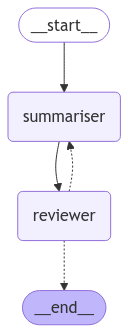

In [34]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

### Execute the Graph!

In [35]:
output = graph.invoke({"summaries": summaries})

In [36]:
final_summary = output["created_summaries"][-1]

display(Markdown(final_summary))


<h1>Big Company Updates 🌟</h1>

<h2>Key Highlights</h2>
<ul>
<li><strong>Q4 2024 Trends 📈:</strong> Discover how tariff talks and agentic AI are making waves among companies. <a href="https://itbrief.co.uk/story/q4-2024-report-shows-rise-in-tariff-agentic-ai-talks">Explore the full insights</a></li>
<li><strong>Agentic AI's Future 🤖:</strong> Will humans become unnecessary? Dive into Jesse Anglen's predictions. <a href="https://www.youtube.com/watch?v=HRzS6YHB82I">Watch the discussion</a></li>
<li><strong>Top Data & AI Trends 2025 🔍:</strong> Uncover AI's role in cost reduction and the importance of processes. <a href="https://towardsdatascience.com/top-10-data-ai-trends-for-2025-4ed785cafe16">Read the article</a></li>
<li><strong>UK's AI Leadership 🇬🇧:</strong> Salesforce's significant role in advancing UK's agentic AI scene. <a href="https://www.okoone.com/spark/technology-innovation/salesforce-backs-the-uks-role-in-driving-agentic-ai-growth/">Learn more</a></li>
<li><strong>Nvidia & Accenture Partnership 🤝:</strong> Aiming to enhance agentic AI in enterprises. <a href="https://aibusiness.com/automation/nvidia-accenture-join-forces-to-boost-agentic-ai-in-enterprise">Discover the collaboration</a></li>
<li><strong>OpenAI Expands ChatGPT 🌐:</strong> ChatGPT search now available to all! <a href="https://www.linkedin.com/news/story/openai-opens-search-to-all-users-6501729/">Find out more</a></li>
<li><strong>ERGO GPT Launch 🚀:</strong> ERGO Group's new AI model for employees. <a href="https://www.linkedin.com/posts/ergo-group-ag_ergo-gpt-a-safe-genai-for-ergo-employees-activity-7274723231725453312-sw_d?utm_source=share&utm_medium=member_desktop">See the details</a></li>
<li><strong>UNSW & OpenAI Partnership 🏫:</strong> How AI is transforming campus life. <a href="https://www.cyberdaily.au/tech/11507-unsw-signs-partnership-agreement-with-openai">Read about this partnership</a></li>
</ul>

<h2>Deeper Dive</h2>

<h3>1. Q4 2024 Trends 🌟</h3>
<p>The IoT Analytics report highlights a surge in tariff discussions, the highest since 2019, due to the U.S. election. Companies are also increasingly mentioning reshoring and agentic AI, while topics like generative AI see a decline. <a href="https://itbrief.co.uk/story/q4-2024-report-shows-rise-in-tariff-agentic-ai-talks">Explore the full insights</a></p>

<h3>2. Agentic AI's Future 🤖</h3>
<p>Jesse Anglen emphasizes the growing role of agentic AI in automating workflows and reducing human dependency. He highlights the balance needed between AI automation and human oversight. <a href="https://www.youtube.com/watch?v=HRzS6YHB82I">Watch the discussion</a></p>

<h3>3. Top Data & AI Trends 2025 🔍</h3>
<p>Insights from industry experts reveal that AI's success is more about the processes than the tools. AI is seen as a cost reducer rather than a revenue generator, with a shift towards smaller, more efficient models. <a href="https://towardsdatascience.com/top-10-data-ai-trends-for-2025-4ed785cafe16">Read the article</a></p>

<h3>4. UK's AI Leadership 🇬🇧</h3>
<p>The UK is leading G7 peers in AI readiness, supported by Salesforce's $4 billion investment. The country's balanced regulatory environment fosters innovation and talent development. <a href="https://www.okoone.com/spark/technology-innovation/salesforce-backs-the-uks-role-in-driving-agentic-ai-growth/">Learn more</a></p>

<h3>5. Nvidia & Accenture Partnership 🤝</h3>
<p>This partnership aims to enhance enterprise operations with agentic AI, potentially transforming industries with autonomous systems. Nvidia and Accenture are focusing on scalability and innovation. <a href="https://aibusiness.com/automation/nvidia-accenture-join-forces-to-boost-agentic-ai-in-enterprise">Discover the collaboration</a></p>

<h3>6. OpenAI Expands ChatGPT 🌐</h3>
<p>OpenAI's ChatGPT search is now available to all users, challenging Google's dominance. This expansion is part of a broader trend of AI integration into search engines, offering a more personalized experience. <a href="https://www.linkedin.com/news/story/openai-opens-search-to-all-users-6501729/">Find out more</a></p>

<h3>7. ERGO GPT Launch 🚀</h3>
<p>ERGO Group's AI model, ERGO GPT, is designed for secure internal use, enhancing data-driven operations. The initiative positions ERGO as a digital leader in the insurance sector. <a href="https://www.linkedin.com/posts/ergo-group-ag_ergo-gpt-a-safe-genai-for-ergo-employees-activity-7274723231725453312-sw_d?utm_source=share&utm_medium=member_desktop">See the details</a></p>

<h3>8. UNSW & OpenAI Partnership 🏫</h3>
<p>The partnership with OpenAI allows UNSW to integrate AI into its campus, enhancing educational and operational capabilities. This collaboration is a pioneer in the Asia-Pacific region. <a href="https://www.cyberdaily.au/tech/11507-unsw-signs-partnership-agreement-with-openai">Read about this partnership</a></p>

<h1>Industry Trends 📈</h1>

<h2>Key Highlights</h2>
<ul>
<li><strong>AI Agent Investments 💼:</strong> Big Tech's focus on agentic AI with new platforms and tools. <a href="https://medium.com/@mcunningham1440/big-tech-is-now-all-in-on-ai-agents-4ccc5970ed57">Discover the trend</a></li>
<li><strong>Unified Communications Predictions 🔮:</strong> Agentic AI and hybrid work models shaping the future. <a href="https://www.uctoday.com/?p=76944">Explore predictions</a></li>
<li><strong>Google's Gemini Model 🚀:</strong> Advanced AI capabilities for agentic applications. <a href="https://cloudwars.com/ai/google-launches-new-gemini-model-designed-for-agentic-ai-use-cases/">Learn about the model</a></li>
</ul>

<h2>Deeper Dive</h2>

<h3>1. AI Agent Investments 💼</h3>
<p>Tech giants like Google, Microsoft, and Salesforce are heavily investing in AI agents to automate tasks and enhance enterprise efficiency. These investments reflect a competitive race to lead in AI innovation. <a href="https://medium.com/@mcunningham1440/big-tech-is-now-all-in-on-ai-agents-4ccc5970ed57">Discover the trend</a></p>

<h3>2. Unified Communications Predictions 🔮</h3>
<p>The UC industry is evolving with the integration of agentic AI and hybrid work models. Companies are expanding their platforms to include AI-driven insights and seamless communication systems. <a href="https://www.uctoday.com/?p=76944">Explore predictions</a></p>

<h3>3. Google's Gemini Model 🚀</h3>
<p>Google's Gemini 2.0 model focuses on agentic AI, offering enhanced capabilities for complex tasks. This positions Google as a leader in developing robust AI solutions. <a href="https://cloudwars.com/ai/google-launches-new-gemini-model-designed-for-agentic-ai-use-cases/">Learn about the model</a></p>

## Send the Email

In [ ]:
def send_email(email_content: str):
    """Send email using Sendinblue API"""
    configuration = sib_api_v3_sdk.Configuration()
    configuration.api_key['api-key'] = os.getenv("SENDINBLUE_API_KEY")
    
    api_instance = sib_api_v3_sdk.TransactionalEmailsApi(sib_api_v3_sdk.ApiClient(configuration))
    
    email_params = {
        "subject": "Daily AI Research Summary",
        "sender": {"name": "shaheer zaman", "email": "shaheer@gmail.com"},
        "html_content": email_content,
        "to": [{"email": "shaheer@gmail.com", "name": "shaheer zaman"}],
        "params": {"subject": "Daily AI Research Summary"}
    }
    
    send_smtp_email = sib_api_v3_sdk.SendSmtpEmail(**email_params)
    
    try:
        api_response = api_instance.send_transac_email(send_smtp_email)
        print(api_response)
    except ApiException as e:
        print(f"Exception when calling SMTPApi->send_transac_email: {e}\n")



send_email(final_summary)


{'message_id': '<202412171952.38151297455@smtp-relay.mailin.fr>',
 'message_ids': None}
